In [1]:
%matplotlib inline

import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time


from skimage import color
from skimage import io
from os import path
from skimage import img_as_float

/Users/Xiaonan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from skimage import color
from skimage import io
from os import path
from skimage import img_as_float

In [3]:
# this shoes_df_10000.pkl is actually 9971 items
data_df = pd.read_pickle('shoes_df_10000.pkl')

In [4]:
item_lst = data_df.item_id  # list of item_id (9971  in total for now)
target = data_df.label  # y- final classification label

In [5]:
item_lst.shape

(9971,)

In [6]:
data_df.head(3)

,item_id,cat_id,term,cnt_purchase,popularity,label
0,516816,284,"123950,175146,116593,70387,117664,56917,22837,...",121.0,very_popular,1
1,250737,284,"56917,123950,129343,116593,22837,31897,83631,1...",40.0,very_popular,1
2,3209233,284,"67965,67630,58018,136479,82230,158346,91747,12...",24.0,very_popular,1


In [10]:
data_df.cnt_purchase.describe()

count    9971.000000
mean       40.181827
std       107.902486
min         1.000000
25%         4.000000
50%         6.000000
75%        34.000000
max      3038.000000
Name: cnt_purchase, dtype: float64

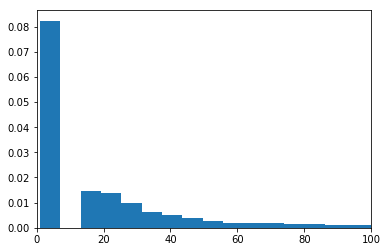

In [12]:
plt.hist(data_df.cnt_purchase, bins = 500, normed= True)
plt.xlim([0,100])
plt.show()

# extract Daisy feature from images

In [ ]:
by running this, imageVectorized is obtained(daisy feature extraction from item_lst(100 item))
with Steps:

1) load original image.
2) convert color to gray image and then resize to(300*300 = 90000 pixel).
3) now convert to 9 DAISY descriptors extracted each part 104 features for each image
(in total 3*3*104 = 936 feature/image).
4) do it with n_sample = 100

In [ ]:
# loadImage function
def loadImage(imagePath,imgId,type='.jpg'):
    fullpath=imagePath+'/'+str(imgId)+type
    if path.exists(fullpath): # check if this path exisits
        image = io.imread(fullpath)
        return image
    else:
        return None

imgLoadPath="selected_image/lst_10000"

In [ ]:
start = time()

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        # covert color image to gray(intensity will be in (0,1) range)
        image=color.rgb2grey(image)
        #resize image make sure they are all the same size
        image=resize(image,(300,300), mode='reflect')
        # extract Daisy feature( can tune this part later)
        descs=daisy(image, step=100, radius=40, rings=2, histograms=6,
                         orientations=8, visualize=False)
        
#        descs, descs_img=daisy(image, step=100, radius=40, rings=2, histograms=6,
#                         orientations=8, visualize=True)
        # show the image, could be commented for accelerating
#        fig, ax = plt.subplots()
#        ax.axis('off')
#        ax.imshow(descs_img)
#        plt.show()                
        
        descs=descs.reshape(1,-1)
        if 'imageVectorized' not in globals(): # meaning it is empty
            imageVectorized=descs
        else:
            imageVectorized=np.append(imageVectorized,descs,axis=0)
    if i%500 == 0:
        print i
        
print("this takes %.2f seconds" %(time()-start)) 

In [ ]:
# run this before, now just load

In [13]:
imageVectorized_10000 = np.load('imageVectorized_10000.npy')

# imageVectorized_10000.shape: (9971, 936)

In [ ]:
pca = PCA(n_components=50)
pca.fit(imageVectorized_10000)
imagePCAed_10000 =pca.transform(imageVectorized_10000)

In [14]:
# this is after PCA (50 components)
imagePCAed_10000 = np.load('imagePCAed_10000.npy')
imagePCAed_10000.shape

(9971, 50)

In [15]:
daisy_PCA = pd.DataFrame(imagePCAed_10000)
daisy_PCA.shape

(9971, 50)

In [16]:
daisy_PCA.columns = ['daisy_PCA_' + str(i) for i in np.arange(daisy_PCA.shape[1])]

# Only train on daisy feature

In [17]:
X = daisy_PCA # 50 components
y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 50)
<class 'pandas.core.series.Series'> (9971,)


In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 50


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

/Users/Xiaonan/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [21]:
# plot feature importance

scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on random forest with best parameters
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini'
                           ,bootstrap = True, max_features = 'sqrt')

model = rf.fit(X_train, y_train)


In [22]:
# see the real accuracy on test dataset: 0.523(only daisy_PCA(50))

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.540


In [23]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.56      0.53      0.54      1027
    popular       0.52      0.55      0.54       968

avg / total       0.54      0.54      0.54      1995



In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    #target_predicted_proba[:, 1] is to use the right one for threshold
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show();



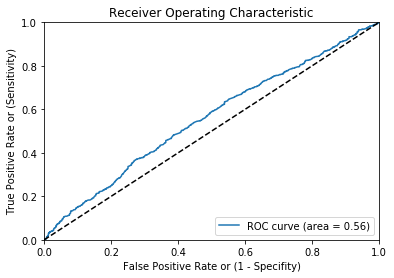

In [27]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

# Michelson contrast : 
(Imax - Imin)/(Imax + Imin)

In [28]:
def get_contrast(color_image): # this is essentially change color to black-white pictures
    image = img_as_float(color_image)
    brightness = np.dot(image, [0.2126,0.7152,0.0722])
#     brightness = brightness.ravel() # make it a flatten list of black-white
    contrast = (brightness.max()-brightness.min())/(brightness.max()+brightness.min())
    return contrast

In [29]:
item_lst.shape

(9971,)

In [31]:
from time import time
# new path
imgLoadPath="../selected_image/old_selected/lst_10000"

In [33]:
# loadImage function
def loadImage(imagePath,imgId,type='.jpg'):
    fullpath=imagePath+'/'+str(imgId)+type
    if path.exists(fullpath): # check if this path exisits
        image = io.imread(fullpath)
        return image
    else:
        return None

In [34]:
# Michelson contrast : 
# item_lst = data_df.item_id  # list of item_id ( 14947 in total for now)
# target = data_df.label  # y- final classification label

start = time()
contrast = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        result = get_contrast(image) # this is a list of length 2 feature
    contrast.append(result)

contrast = np.array(contrast)

print("this takes %.2f seconds" %(time()-start)) 

this takes 332.48 seconds


In [35]:
contrast.shape

(9971,)

In [36]:
contrast = pd.DataFrame(contrast)
contrast.columns = ['contrast']

In [92]:
np.save('contrast_10000.npy',contrast)

# RMScontrast

In [37]:
def get_RMScontrast(color_image): # this is essentially change color to black-white pictures
    image = img_as_float(color_image)
    brightness = np.dot(image, [0.2126,0.7152,0.0722])
    brightness = brightness.ravel() # make it a flatten list of black-white
    brightness_mean = brightness.mean()
    RMScontrast = np.square(brightness - brightness_mean).sum()/len(brightness)
    return RMScontrast

In [38]:
# Michelson contrast : 
# item_lst = data_df.item_id  # list of item_id ( 14947 in total for now)
# target = data_df.label  # y- final classification label

start = time()
RMScontrast = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        result = get_RMScontrast(image) # this is a list of length 2 feature
    RMScontrast.append(result)

RMScontrast = np.array(RMScontrast)

print("this takes %.2f seconds" %(time()-start)) 

this takes 341.52 seconds


In [39]:
RMScontrast.shape

(9971,)

In [40]:
RMScontrast = pd.DataFrame(RMScontrast)
RMScontrast.columns = ['contrast_' + str(i) for i in np.arange(contrast.shape[1])]

In [93]:
np.save('RMScontrast_10000.npy',RMScontrast)

In [320]:
RMScontrast.to_csv('saved_file/RMScontrast.csv', index = False)

# Get HSV (hue, saturation and value features)

In [41]:
def get_HSV(color_image):
    image = color.rgb2hsv(color_image)
    hue = image[:,:,0].mean()
    saturation = image[:,:,1].mean()
    value = image[:,:,2].mean()
    
    result = [hue, saturation, value]
    return result

In [42]:
# item_lst = data_df.item_id  # list of item_id ( 14947 in total for now)
# target = data_df.label  # y- final classification label

start = time()
HSV = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        result = get_HSV(image) # this is a list of length 2 feature
    HSV.append(result)

HSV = np.array(HSV)

print("this takes %.2f seconds" %(time()-start)) 

this takes 523.55 seconds


In [43]:
HSV.shape

(9971, 3)

In [44]:
HSV = pd.DataFrame(HSV)
HSV.columns = ['HSV_hue', 'HSV_saturation','HSV_value']

In [94]:
np.save('HSV_10000.npy',HSV)

# get brightness

In [45]:
def get_brightness(color_image): # this is essentially change color to black-white pictures
    image = img_as_float(color_image)
    brightness = np.dot(image, [0.2126,0.7152,0.0722])
    brightness = brightness.ravel() # make it a flatten list
    result = [np.mean(brightness), np.median(brightness)]
    return result

In [46]:
# item_lst = data_df.item_id  # list of item_id ( 1995 in total for now)
# target = data_df.label  # y- final classification label

start = time()
brightness = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        bright = get_brightness(image) # this is a list of length 2 feature
    brightness.append(bright)

brightness = np.array(brightness)

print("this takes %.2f seconds" %(time()-start)) 

this takes 303.78 seconds


In [47]:
brightness.shape

(9971, 2)

In [48]:
brightness = pd.DataFrame(brightness)
brightness.columns = ['brightness_mean', 'brightness_median']

In [49]:
brightness.head(1)

,brightness_mean,brightness_median
0,0.725045,0.767913


In [95]:
np.save('brightness.npy',brightness)

In [318]:
brightness.to_csv('saved_file/brightness.csv', index = False)

In [319]:
brightness.shape

(9971, 2)

# Get Color intensity Mean and median

In [50]:
def get_color_mean(color_image): 
    color_image = img_as_float(color_image)
    red_image = color_image[:,:,0].ravel()
    green_image = color_image[:,:,1].ravel()
    blue_image = color_image[:,:,2].ravel()
    
    color_list = [red_image,green_image,blue_image]
    
    
    color_mean = [] 
    
    for single_color in color_list:
        mean_single = [np.mean(single_color), np.median(single_color)]
        color_mean += mean_single
    return color_mean

In [51]:
# item_lst = data_df.item_id  # list of item_id (9971 in total for now)
# target = data_df.label  # y- final classification label

start = time()
color_mean = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        result = get_color_mean(image) # this is a list of 6 features(mean and median for each color)
    color_mean.append(result)

color_mean = np.array(color_mean)

print("this takes %.2f seconds" %(time()-start)) 

this takes 308.12 seconds


In [52]:
color_mean.shape

(9971, 6)

In [53]:
color_mean = pd.DataFrame(color_mean)
color_mean.columns = ['color_mean_red','color_median_red',
                     'color_mean_green','color_median_green',
                     'color_mean_blue','color_median_blue']

In [54]:
color_mean.head(1)

,color_mean_red,color_median_red,color_mean_green,color_median_green,color_mean_blue,color_median_blue
0,0.734114,0.772549,0.723753,0.768627,0.711134,0.768627


In [96]:
np.save('color_mean.npy',color_mean)

In [317]:
color_mean.to_csv('saved_file/color_mean.csv', index = False)

# Get color_features(RGB histogram)

In [55]:
# write a function to get a color image's RGB color histogram:
# each color, we will have 4 values( 4 bins, value is its corresponding normalized cnt)
def get_RGB_hist(color_image):
    red_image = color_image[:,:,0].ravel()
    green_image = color_image[:,:,1].ravel()
    blue_image = color_image[:,:,2].ravel()
    
    color_list = [red_image,green_image,blue_image]
    
    #calculate histgram's value_counts for peaks in each color
    color_hist_lst = [] # it will follow as red feature + green + blue(4*3 = 12 features)
    
    for single_color in color_list:
        hist,bins = np.histogram(single_color,4,[0,256], normed= True, density= True)
        unity_hist = hist / hist.sum()  # normalize it to make sure unity_hist.sum() = 1
    
        color_hist_lst += unity_hist.tolist()
    
    #return a 12 feature list(4*3)
    return color_hist_lst

In [56]:
# item_lst = data_df.item_id  # list of item_id (9971 in total for now)
# target = data_df.label  # y- final classification label

start = time()
color_hist = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        hue = get_RGB_hist(image) # this is a list of length 48 features
    color_hist.append(hue)

color_hist = np.array(color_hist)

print("this takes %.2f seconds" %(time()-start)) 

this takes 335.38 seconds


In [57]:
color_hist = pd.DataFrame(color_hist)
color_hist.columns = ['color_hist_' + str(i) for i in np.arange(color_hist.shape[1])]

In [58]:
color_hist.head(1)

,color_hist_0,color_hist_1,color_hist_2,color_hist_3,color_hist_4,color_hist_5,color_hist_6,color_hist_7,color_hist_8,color_hist_9,color_hist_10,color_hist_11
0,0.036826,0.04415,0.329902,0.589121,0.035732,0.055645,0.352754,0.555869,0.048682,0.056621,0.35333,0.541367


In [59]:
color_hist.shape

(9971, 12)

In [97]:
np.save('color_hist.npy',color_hist)

In [316]:
color_hist.to_csv('saved_file/color_hist.csv', index = False)

# Training: use all features without daisy
    

    1) Michelson contrast --contrast
    2) RMScontrast --RMScontrast
    3) Get HSV (hue, saturation and value features) --HSV
    4) get brightness --brightness
    5) Get Color intensity Mean and median --color_mean
    6) Get color_features(RGB histogram) --color_hist

In [60]:
# use 1)color_mean(6), 2)brightness(2), 3) HSV(3), 4)RMScontrast(1), 5) contrast(1) and 6) color_hist (12 features)
X = pd.concat([color_hist, color_mean, brightness,
              HSV, RMScontrast, contrast],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 25)
<class 'pandas.core.series.Series'> (9971,)


In [61]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 25


# Random Forest

In [62]:
# plot feature importance

scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on random forest with best parameters
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini'
                           ,bootstrap = True, max_features = 'sqrt')

model = rf.fit(X_train, y_train)

In [63]:
# see the real accuracy on test dataset: 0.513(only daisy_PCA(30))

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.507


In [64]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.52      0.49      0.51      1027
    popular       0.49      0.52      0.51       968

avg / total       0.51      0.51      0.51      1995



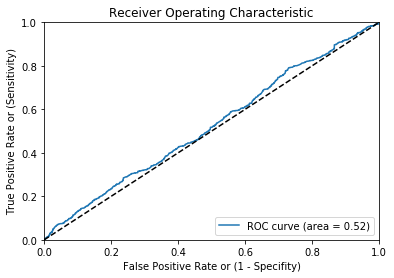

In [65]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

In [67]:
# function to plot feature_importance.
def plot_feature_importance(feature_importances,feature_names):
    ftr_imp_df = pd.DataFrame(sorted(zip(feature_names,feature_importances)
                          , key=lambda x: x[1], reverse = True)
                   )
    y_pos = np.arange(ftr_imp_df.shape[0])
    # plot top 10 features 
    plt.barh(y_pos[:10], ftr_imp_df[1][:10], align='center', alpha=0.4)
    plt.yticks(y_pos[:10], ftr_imp_df[0][:10])
    plt.xlabel('Feature Importance')

    plt.show()

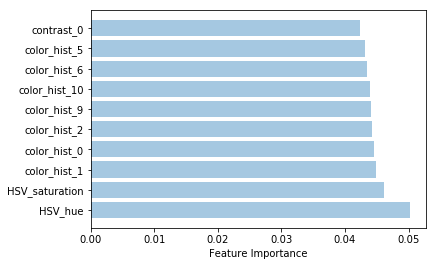

In [68]:
# make a plot of feature importance

#Plot feature importance in rf
feature_names = X.columns # the number here indicate to the vectorized PCA number
plot_feature_importance(model.feature_importances_, feature_names)

# Re-train: use all features including DaisyPCA

In [69]:
# use 1)color_mean(6), 2)brightness(2), 3) HSV(3), 4)RMScontrast(1),
#   5) contrast(1) and 6) color_hist (12 features), 7)daisy_PCA
X = pd.concat([daisy_PCA, color_hist, color_mean, brightness,
              HSV, RMScontrast, contrast],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 75)
<class 'pandas.core.series.Series'> (9971,)


In [70]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 75


In [98]:
#Random Forest

In [71]:
# plot feature importance

scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on random forest with best parameters
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini'
                           ,bootstrap = True, max_features = 'sqrt')

model = rf.fit(X_train, y_train)

In [72]:
# see the real accuracy on test dataset: 0.513(only daisy_PCA(30))

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.533


In [73]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.55      0.53      0.54      1027
    popular       0.52      0.54      0.53       968

avg / total       0.53      0.53      0.53      1995



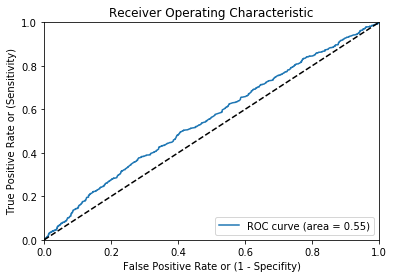

In [74]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

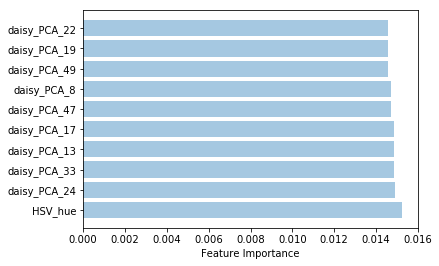

In [75]:
# make a plot of feature importance

#Plot feature importance in rf
feature_names = X.columns # the number here indicate to the vectorized PCA number
plot_feature_importance(model.feature_importances_, feature_names)

In [76]:
from sklearn.metrics import precision_score

score = precision_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.518


# Logistic regression

In [87]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 5, random_state= 1234)
model = logreg.fit(X_train, y_train)


In [88]:
# see the real accuracy on test dataset

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.545


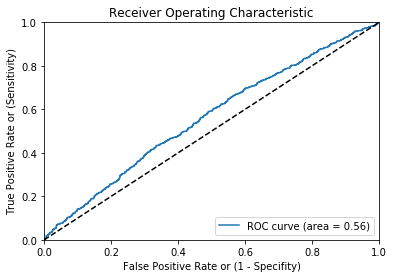

In [89]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

In [90]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.57      0.50      0.53      1027
    popular       0.53      0.59      0.56       968

avg / total       0.55      0.54      0.54      1995



In [91]:
# see the real accuracy on test dataset

from sklearn.metrics import precision_score

y_pred = model.predict(X_test)

score = precision_score(y_test, y_pred)

print("test dataset accuracy score using logreg with three parts of features: %.3f" %score)

test dataset accuracy score using logreg with three parts of features: 0.528


# New Daisy---extract Daisy feature from images
# mask top :50, to extract partial Daisy -- did this Monday night

In [99]:
# loadImage function
def loadImage(imagePath,imgId,type='.jpg'):
    fullpath=imagePath+'/'+str(imgId)+type
    if path.exists(fullpath): # check if this path exisits
        image = io.imread(fullpath)
        return image
    else:
        return None


In [273]:
imgLoadPath="../selected_image/old_selected/lst_10000"

    Grid of DAISY descriptors for the given image as an array dimensionality (P, Q, R) where
    P = ceil((M - radius*2) / step) 
    Q = ceil((N - radius*2) / step) 
    R = (rings* histograms + 1) * orientations
    daisy(img, step=150, radius=33, rings=3, histograms=3, orientations=3, visualize=True)来提取图片，则会得到（2,2,30）

In [101]:
from skimage.transform import resize
from skimage.feature import daisy

In [ ]:
partial = image[50:,:,:] # partial image
image=color.rgb2grey(partial)
#resize image make sure they are all the same size
image=resize(image,(260,300), mode='reflect')
# extract Daisy feature( can tune this part later)
descs=daisy(image, step=100, radius=40, rings=2, histograms=6,
                 orientations=8, visualize=False)
descs.shape

In [277]:
start = time()

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        # covert color image to gray(intensity will be in (0,1) range)
        image=color.rgb2grey(image)
        partial = image[50:,:] # partial image
        #resize image make sure they are all the same size
        partial=resize(partial,(250,300), mode='reflect')
        # extract Daisy feature( can tune this part later)
        descs=daisy(partial, step=100, radius=40, rings=2, histograms=6,
                 orientations=8, visualize=False)
#        descs, descs_img=daisy(image, step=100, radius=40, rings=2, histograms=6,
#                         orientations=8, visualize=True)
        # show the image, could be commented for accelerating
#        fig, ax = plt.subplots()
#        ax.axis('off')
#        ax.imshow(descs_img)
#        plt.show()                
        
        descs=descs.reshape(1,-1)
        if 'imageVectorized_2' not in globals(): # meaning it is empty
            imageVectorized_2=descs
        else:
            imageVectorized_2=np.append(imageVectorized_2,descs,axis=0)
    if i%500 == 0:
        print i
        
print("this takes %.2f seconds" %(time()-start)) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
this takes 3802.35 seconds


In [109]:
imageVectorized_new.shape # not so good compare with old 936 features one

(9971, 120)

In [104]:
item_lst.shape

(9971,)

In [278]:
imageVectorized_2.shape

(9971, 624)

In [279]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(imageVectorized_2)
imagePCAed_2 =pca.transform(imageVectorized_2)

In [280]:
daisy_PCA_2 = pd.DataFrame(imagePCAed_2)
daisy_PCA_2.shape

(9971, 50)

In [281]:
daisy_PCA_2.columns = ['daisy_PCA2_' + str(i) for i in np.arange(daisy_PCA_2.shape[1])]

# Only train on Daisy_PCA_2 -not as good as Daisy_PCA
# now try a new one, mask to the top :50 to get new Daisy partial

In [282]:
X = daisy_PCA_2 # 50 components
y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 50)
<class 'pandas.core.series.Series'> (9971,)


In [283]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 50


In [ ]:
#Logistic regression

In [284]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 5, random_state= 1234)
model = logreg.fit(X_train, y_train)


In [285]:
# see the real accuracy on test dataset: 0.52--logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.524


#Random forest

In [286]:
# plot feature importance

scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on random forest with best parameters
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini'
                           ,bootstrap = True, max_features = 'sqrt')

model = rf.fit(X_train, y_train)


In [287]:
# see the real accuracy on test dataset: 0.52--logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.541


In [288]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.56      0.53      0.55      1027
    popular       0.53      0.55      0.54       968

avg / total       0.54      0.54      0.54      1995



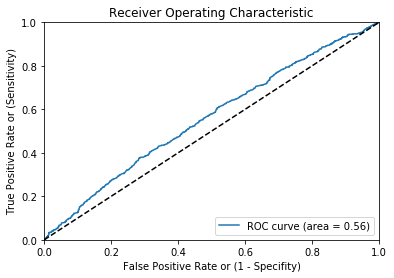

In [289]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

# Get Hue's histogram data as a new feature

In [105]:
def get_Hue_hist(color_image):
    image = color.rgb2hsv(color_image)
    hue = image[:,:,0].ravel()
    hist,bins = np.histogram(hue, 4,[0,1], normed= True, density= True) #this will have 4 bins
    hue_unity_hist = hist / hist.sum()  # normalize it to make sure unity_hist.sum() = 1
    
    return hue_unity_hist

In [106]:
# item_lst = data_df.item_id  # list of item_id (9971 in total for now)
# target = data_df.label  # y- final classification label

start = time()
hue_hist = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        hue = get_Hue_hist(image) # this is a list of length 48 features
    hue_hist.append(hue)

hue_hist = np.array(hue_hist)

print("this takes %.2f seconds" %(time()-start)) 

this takes 460.11 seconds


In [107]:
hue_hist.shape

(9971, 4)

In [108]:
hue_hist = pd.DataFrame(hue_hist)
hue_hist.columns = ['hue_hist_' + str(i) for i in np.arange(hue_hist.shape[1])]

In [321]:
hue_hist.to_csv('saved_file/hue_hist.csv', index = False)

In [322]:
hue_hist.shape

(9971, 4)

# Retrain model-- with more features

In [122]:
# use 1)color_mean(6), 2)brightness(2), 3) HSV(3), 4)RMScontrast(1),
#   5) contrast(1) and 6) color_hist (12 features), 7)daisy_PCA, 8) hue_hist
X = pd.concat([daisy_PCA, color_hist, color_mean,
               brightness, HSV, RMScontrast, 
               contrast, hue_hist],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 79)
<class 'pandas.core.series.Series'> (9971,)


In [123]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 79


# Train on Random Forest

In [124]:
# plot feature importance

scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on random forest with best parameters
rf = RandomForestClassifier(n_estimators= 500, random_state= 1234, criterion='gini'
                           ,bootstrap = True, max_features = 'sqrt')

model = rf.fit(X_train, y_train)


In [125]:
# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.535


In [126]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.55      0.53      0.54      1027
    popular       0.52      0.54      0.53       968

avg / total       0.54      0.53      0.53      1995



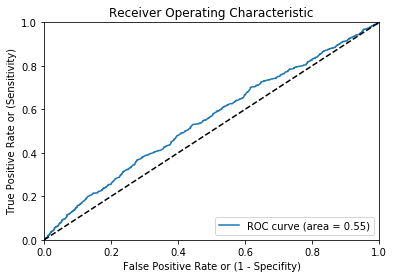

In [127]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

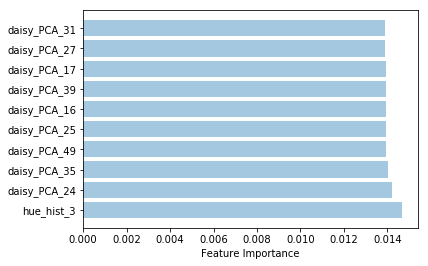

In [128]:
# make a plot of feature importance

#Plot feature importance in rf
feature_names = X.columns # the number here indicate to the vectorized PCA number
plot_feature_importance(model.feature_importances_, feature_names)

# logistic regression

In [129]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 5, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)


test dataset accuracy score: 0.548


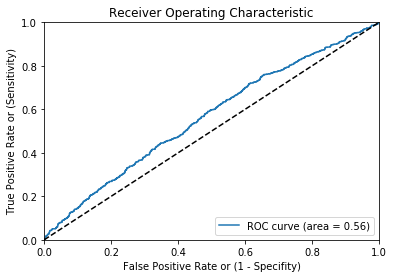

In [130]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

In [131]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.57      0.51      0.54      1027
    popular       0.53      0.59      0.56       968

avg / total       0.55      0.55      0.55      1995



In [136]:
X.columns.shape

(79,)

In [133]:
model.coef_ #shape: 1,79

array([[-0.30688868, -0.70503308, -0.5002983 , -0.38870709, -0.71653733,
         1.41749676, -1.33012758, -1.59845363, -0.29855152, -0.54863182,
         0.28437491,  2.38274412,  0.12074026, -0.97635139,  0.13776711,
         0.95007474,  1.75267161, -1.16377134, -0.10481892,  0.95809062,
        -0.4275962 , -0.04811872, -1.80253266,  0.31447434,  2.55001033,
        -1.02440306, -1.20331171,  0.60258342,  0.13462899, -1.17096397,
         0.3904507 ,  1.38662613,  0.44277549, -2.60596762,  0.73568985,
        -1.4634847 , -0.79973295,  0.51776956,  0.19315275, -2.22011056,
        -1.10539538, -0.44056603, -0.13029564,  1.32613128,  0.26880693,
         1.05213636, -0.39427288, -0.00901893, -0.46956658,  1.26085623,
        -0.00574248, -0.0669964 , -0.05444538, -1.04030583, -0.59505732,
        -0.9571826 , -0.37134428,  0.75609411,  0.18965574,  0.23660667,
        -0.51275166, -1.08100084,  0.01535794,  0.89730916, -0.41077033,
         0.01437539,  2.15133458,  0.29552954, -0.1

In [149]:
abs(model.coef_)[0].shape # give them an absolute value

(79,)

In [150]:
feature_importances = abs(model.coef_)[0]
feature_names = X.columns
sorted_feature = pd.DataFrame(sorted(zip(feature_importances, feature_names), 
                                         key = lambda x:x[0], reverse = True)
                                 )
sorted_feature.shape

(79, 2)

In [158]:
sorted_feature[1][:20]

0        daisy_PCA_33
1        daisy_PCA_24
2        daisy_PCA_11
3        daisy_PCA_39
4     color_mean_blue
5        daisy_PCA_22
6        daisy_PCA_16
7             HSV_hue
8         daisy_PCA_7
9        daisy_PCA_35
10        daisy_PCA_5
11       daisy_PCA_31
12        daisy_PCA_6
13       daisy_PCA_43
14       daisy_PCA_49
15       daisy_PCA_26
16           contrast
17       daisy_PCA_29
18       daisy_PCA_17
19       daisy_PCA_40
Name: 1, dtype: object

In [155]:
sorted_feature[0][:15]

0     2.605968
1     2.550010
2     2.382744
3     2.220111
4     2.151335
5     1.802533
6     1.752672
7     1.684115
8     1.598454
9     1.463485
10    1.417497
11    1.386626
12    1.330128
13    1.326131
14    1.260856
Name: 0, dtype: float64

In [156]:
# function to plot feature_importance.
def plot_feature_importance_logreg(feature_importances,feature_names):
    feature_importances = abs(feature_importances)[0]
    sorted_feature = pd.DataFrame(sorted(zip(feature_importances, feature_names), 
                                         key = lambda x:x[0], reverse = True)
                                 )
    
    y_pos = np.arange(sorted_feature.shape[0])
    # plot top 10 features 
    plt.barh(y_pos[:10], sorted_feature[0][:10], align='center', alpha=0.4)
    plt.yticks(y_pos[:10], sorted_feature[1][:10])
    plt.xlabel('Feature Importance')

    plt.show()

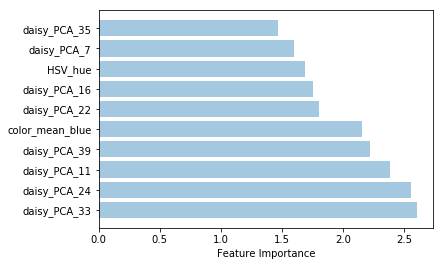

In [157]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

# Training: use all features without daisy(logistic regression)

In [159]:
X = pd.concat([color_hist, color_mean,
               brightness, HSV, RMScontrast, 
               contrast, hue_hist],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 29)
<class 'pandas.core.series.Series'> (9971,)


In [160]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 29


In [161]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 5, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)


test dataset accuracy score: 0.530


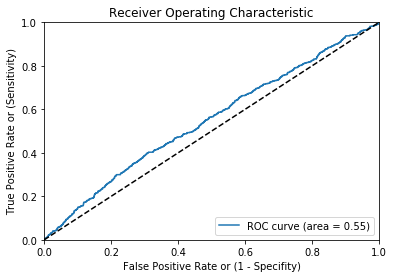

In [162]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

In [163]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.54      0.53      0.54      1027
    popular       0.52      0.53      0.52       968

avg / total       0.53      0.53      0.53      1995



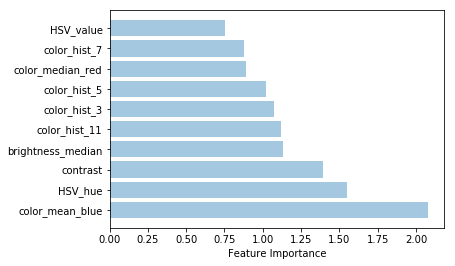

In [164]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

# Try a new PCA on Daisy_feature(old one 936s to get 10 components)

In [166]:
imageVectorized_10000 = np.load('imageVectorized_10000.npy')

# imageVectorized_10000.shape: (9971, 936)


In [167]:
# PCA to 10 components

pca = PCA(n_components=10) 
pca.fit(imageVectorized_10000)
imagePCAed_10 =pca.transform(imageVectorized_10000)

In [168]:
daisy_PCA_10 = pd.DataFrame(imagePCAed_10)
daisy_PCA_10.shape

(9971, 10)

In [169]:
daisy_PCA_10.columns = ['daisy_PCA10_' + str(i) for i in np.arange(daisy_PCA_10.shape[1])]

In [170]:
X = daisy_PCA_10 # 50 components
y = target

print type(X), X.shape
print type(y), y.shape

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

<class 'pandas.core.frame.DataFrame'> (9971, 10)
<class 'pandas.core.series.Series'> (9971,)
training size: 7976
test size: 1995
number of features: 10


In [171]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 5, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)


test dataset accuracy score: 0.532


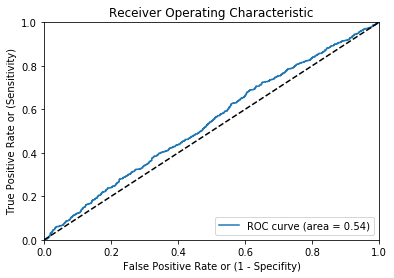

In [172]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

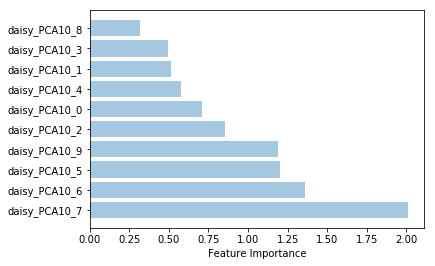

In [173]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

# Combine all features together for logistic regression (new_daisy(different components from 936 features)) --components (10, 8, 5)

In [189]:
pca = PCA(n_components=5) 
pca.fit(imageVectorized_10000)
imagePCAed_5 =pca.transform(imageVectorized_10000)

In [190]:
daisy_PCA_5 = pd.DataFrame(imagePCAed_5)
daisy_PCA_5.shape
daisy_PCA_5.columns = ['daisy_PCA5_' + str(i) for i in np.arange(daisy_PCA_5.shape[1])]

In [224]:
X = pd.concat([color_hist, color_mean,
               brightness, HSV, RMScontrast, 
               contrast, hue_hist,daisy_PCA_5 ],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 34)
<class 'pandas.core.series.Series'> (9971,)


In [225]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 34


In [226]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 10, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)


test dataset accuracy score: 0.553


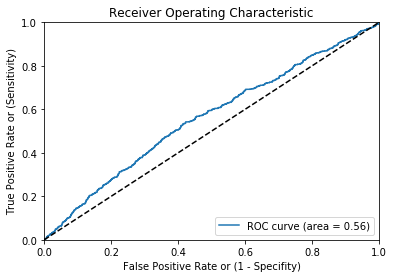

In [227]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

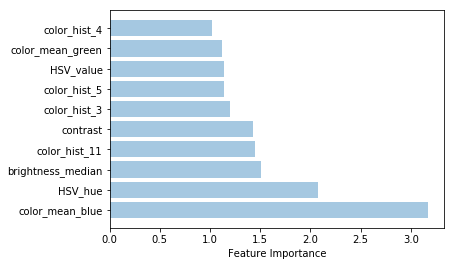

In [228]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

In [229]:
# dive deep for insights on HSV_hue
insight1 = pd.concat([color_mean,
               brightness, HSV,contrast, target], axis = 1)

insight1.head(3)

,color_mean_red,color_median_red,color_mean_green,color_median_green,color_mean_blue,color_median_blue,brightness_mean,brightness_median,HSV_hue,HSV_saturation,HSV_value,contrast,label
0,0.734114,0.772549,0.723753,0.768627,0.711134,0.768627,0.725045,0.767913,0.326814,0.098899,0.754419,1.0,1
1,0.315651,0.286275,0.293695,0.274510,0.298740,0.294118,0.298727,0.279292,0.466457,0.190440,0.334175,1.0,1
2,0.449377,0.486275,0.392159,0.321569,0.357678,0.258824,0.401834,0.352980,0.307869,0.332056,0.467410,1.0,1


In [230]:
insight1.groupby('label').mean()

,color_mean_red,color_median_red,color_mean_green,color_median_green,color_mean_blue,color_median_blue,brightness_mean,brightness_median,HSV_hue,HSV_saturation,HSV_value,contrast
label,,,,,,,,,,,,
0,0.678373,0.739401,0.614180,0.672535,0.585579,0.633756,0.625762,0.682390,0.267260,0.228546,0.694461,0.991428
1,0.658465,0.715193,0.594478,0.646625,0.569065,0.611053,0.606246,0.656882,0.286308,0.236594,0.675187,0.992902


In [232]:
insight1.groupby('label').median()

,color_mean_red,color_median_red,color_mean_green,color_median_green,color_mean_blue,color_median_blue,brightness_mean,brightness_median,HSV_hue,HSV_saturation,HSV_value,contrast
label,,,,,,,,,,,,
0,0.696355,0.788235,0.628998,0.709804,0.592446,0.650980,0.640735,0.718718,0.233820,0.209901,0.711015,1.0
1,0.671017,0.760784,0.600689,0.678431,0.569745,0.623529,0.612130,0.692410,0.253611,0.218112,0.686005,1.0


In [231]:
insight1.groupby('label').std()

,color_mean_red,color_median_red,color_mean_green,color_median_green,color_mean_blue,color_median_blue,brightness_mean,brightness_median,HSV_hue,HSV_saturation,HSV_value,contrast
label,,,,,,,,,,,,
0,0.151098,0.201176,0.153257,0.217194,0.157792,0.223709,0.150673,0.211567,0.154627,0.123945,0.146367,0.030165
1,0.153805,0.208169,0.157854,0.224695,0.158845,0.225797,0.154624,0.218008,0.162096,0.124259,0.150956,0.025435


In [197]:
feature_importances = model.coef_[0]
feature_names = X.columns
sorted_feature = pd.DataFrame(sorted(zip(feature_importances, feature_names), 
                                         key = lambda x:x[0], reverse = True)
                                 )
sorted_feature

,0,1
0,2.118153,color_mean_blue
1,1.687500,HSV_hue
2,1.274579,contrast
3,0.881395,color_median_red
4,0.814303,color_hist_7
5,0.641601,contrast_0
6,0.356482,hue_hist_0
7,0.316009,HSV_saturation
8,0.259382,color_hist_9
9,0.248974,color_median_blue


    # Insights from these features:
    1) color_mean(blue, red, green) : positive coefficient-- lighter color - more popular
    2) HSV_hue: positive coefficient--higher HSV, more popular
    3) contrast: positive coefficient--higher, more popular

# get gray_histgram of image

In [208]:
# write a function to get a color image's RGB color histogram:
# each color, we will have 4 values( 4 bins, value is its corresponding normalized cnt)
def get_gray_hist(color_image):
    image = color.rgb2gray(color_image)

#     #calculate histgram's value_counts for peaks in each color
#     gray_hist_lst = [] # it will follow as gray picture for 4 features)
    
    
    hist,bins = np.histogram(image,4,[0,1], normed= True, density= True)
    unity_hist = hist / hist.sum()  # normalize it to make sure unity_hist.sum() = 1
    
    #return a 4 feature list
    return unity_hist

In [211]:
# item_lst = data_df.item_id  # list of item_id (9971 in total for now)
# target = data_df.label  # y- final classification label

start = time()
gray_hist = [] # this is the final np.array for all images

for i in np.arange(len(item_lst)):
    image=loadImage(imgLoadPath,item_lst[i],type='.jpg')
    if image is not None:
        hue = get_gray_hist(image) # this is a list of length 48 features
    gray_hist.append(hue)

gray_hist = np.array(gray_hist)

print("this takes %.2f seconds" %(time()-start)) 

this takes 192.28 seconds


In [212]:
gray_hist.shape

(9971, 4)

In [213]:

gray_hist = pd.DataFrame(gray_hist)
gray_hist.columns = ['gray_hist_' + str(i) for i in np.arange(gray_hist.shape[1])]

In [ ]:
# reduce some features and see the outcome

In [214]:
X = pd.concat([gray_hist, color_mean,
               brightness, HSV, RMScontrast, 
               contrast, hue_hist,daisy_PCA_5 ],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])


<class 'pandas.core.frame.DataFrame'> (9971, 26)
<class 'pandas.core.series.Series'> (9971,)
training size: 7976
test size: 1995
number of features: 26


In [221]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 10, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.542


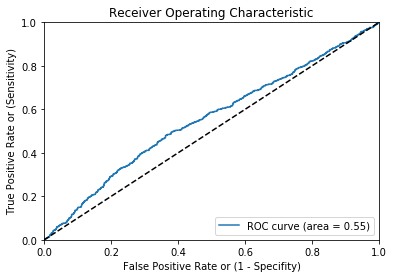

In [222]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

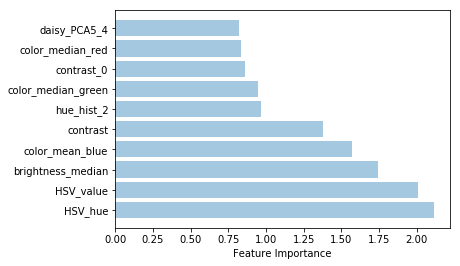

In [223]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

In [ ]:
# get 

In [263]:
X = pd.concat([ brightness,
#                 gray_hist,
               HSV, 
                RMScontrast, 
                hue_hist,
                daisy_PCA_5 ],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.frame.DataFrame'> (9971, 15)
<class 'pandas.core.series.Series'> (9971,)


In [264]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])

training size: 7976
test size: 1995
number of features: 15


In [265]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 10, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)


test dataset accuracy score: 0.540


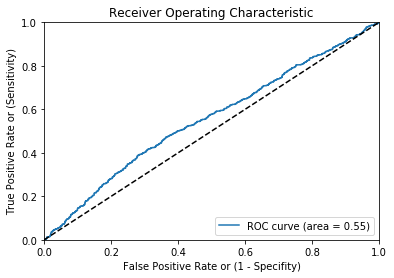

In [266]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

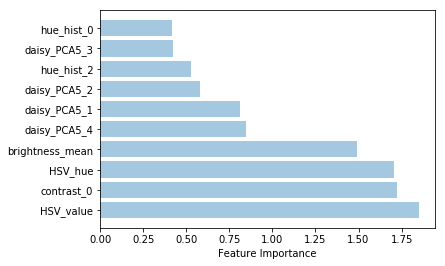

In [267]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

In [268]:
feature_importances = model.coef_[0]
feature_names = X.columns
sorted_feature = pd.DataFrame(sorted(zip(feature_importances, feature_names), 
                                         key = lambda x:x[0], reverse = True)
                                 )
sorted_feature

,0,1
0,1.725612,contrast_0
1,1.703473,HSV_hue
2,1.491018,brightness_mean
3,0.413970,hue_hist_0
4,0.340621,HSV_saturation
5,-0.010101,daisy_PCA5_0
6,-0.036954,hue_hist_1
7,-0.110010,brightness_median
8,-0.255403,hue_hist_3
9,-0.419605,daisy_PCA5_3


# another try without HSV(maybe easier to explain)

In [ ]:
Save this dataset as pd.Dataframe

In [312]:
# X = pd.concat([color_hist, color_mean,
#                brightness, RMScontrast, 
#               hue_hist,daisy_PCA_5],axis = 1)

# y = target

X.to_csv('saved_file/training_1.csv', index = False)
y.to_csv('saved_file/label.csv', index = False)

X.shape
y.shape

(9971,)

In [313]:
brightness.head(2)

,brightness_mean,brightness_median
0,0.725045,0.767913
1,0.298727,0.279292


In [315]:
color_mean.head(3)

,color_mean_red,color_median_red,color_mean_green,color_median_green,color_mean_blue,color_median_blue
0,0.734114,0.772549,0.723753,0.768627,0.711134,0.768627
1,0.315651,0.286275,0.293695,0.274510,0.298740,0.294118
2,0.449377,0.486275,0.392159,0.321569,0.357678,0.258824


In [306]:
X = pd.concat([color_hist, color_mean,
               brightness, RMScontrast, 
              hue_hist,daisy_PCA_5],axis = 1)

y = target

print type(X), X.shape
print type(y), y.shape
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ("training size: %d" % X_train.shape[0])
print ("test size: %d" % X_test.shape[0])
print ('number of features: %d' % X_train.shape[1])


<class 'pandas.core.frame.DataFrame'> (9971, 30)
<class 'pandas.core.series.Series'> (9971,)
training size: 7976
test size: 1995
number of features: 30


In [307]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_train_standardized = scaler.fit_transform(X_train)

# step 2: train on logreg with best parameters
logreg = LogisticRegression(C = 9, random_state= 1234)
model = logreg.fit(X_train, y_train)

# see the real accuracy on test dataset: 0.54 --logistic regression-Daisy_PCA_2

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

print("test dataset accuracy score: %.3f" %score)

test dataset accuracy score: 0.548


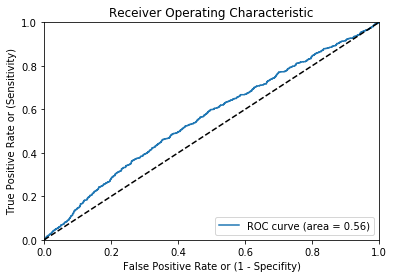

In [308]:
y_pred_prob = model.predict_proba(X_test)
plot_roc_curve(y_test, y_pred_prob)

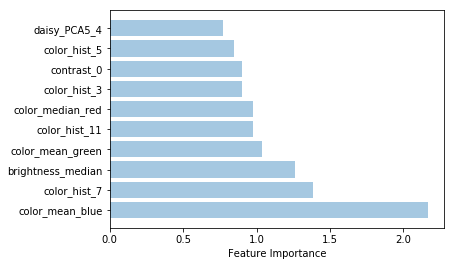

In [309]:
feature_names = X.columns # plot logistic regression importance
plot_feature_importance_logreg(model.coef_, feature_names)

In [310]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
target_names = ['unpopular', 'popular']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

  unpopular       0.56      0.53      0.55      1027
    popular       0.53      0.56      0.55       968

avg / total       0.55      0.55      0.55      1995



In [305]:
# try new daisy_PCA_2 (new Daisy-50 components) --not so good
